In [5]:
import pylab
%matplotlib inline
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (10, 6)
import scipy.optimize
import pandas as pd
from pandas import *
import numpy as np

## helper functions

In [7]:
# Calculates portfolio mean return
def port_mean(W, R):
    return sum(R * W)

# Calculates portfolio variance of returns
def port_var(W, C):
    return np.dot(np.dot(W, C), W)

# Combination of the two functions above
def port_mean_var(W, R, C):
    return port_mean(W, R), port_var(W, C)

In [8]:
# Given risk-free rate, assets returns and covariances, this function calculates
# weights of tangency portfolio with respect to sharpe ratio maximization
def solve_weights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = port_mean_var(W, R, C)  # calculate mean/variance of the portfolio
        util = (mean - rf) / np.sqrt(var)  # utility = Sharpe ratio
        return 1 / util  # maximize the utility, minimize its inverse value
    n = len(R)
    W = np.ones([n]) / n  # start optimization with equal weights
    b_ = [(0., 1.) for i in range(n)]  # weights for boundaries between 0%..100%.
    c_ = [{'type': 'eq', 'fun': lambda W: np.sum(W) - 1.}]  # Sum of weights must be 100%
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

In [9]:
# Given risk-free rate, assets returns and covariances, this function calculates mean-variance frontier and returns its [x,y] points in two arrays
def solve_frontier(R, C, rf):
    def fitness(W, R, C, r):
        # For given level of return r, find weights which minimizes portfolio variance.
        mean, var = port_mean_var(W, R, C)
        penalty = 100 * abs(mean - r)  # Big penalty for not meeting stated portfolio return effectively
        return var + penalty

    frontier_mean, frontier_var, frontier_weights = [], [], []
    n = len(R)  # Number of assets in the portfolio
    for r in np.linspace(min(R), max(R), num=20):  # Iterate through the range of returns on Y axis
        W = np.ones([n]) / n  # start optimization with equal weights
        b_ = [(0, 1) for i in range(n)]
        c_ = [{'type': 'eq', 'fun': lambda W: np.sum(W) - 1.}]
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
            raise BaseException(optimized.message)
        # add point to the efficient frontier [x,y] = [optimized.x, r]
        # print('Mean, Weights and Variance in solve frontier', r, optimized.x, port_var(optimized.x,C))
        frontier_mean.append(r)
        frontier_var.append(port_var(optimized.x, C))
        frontier_weights.append(optimized.x)
    return np.array(frontier_mean), np.array(frontier_var), frontier_weights

In [10]:
class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var, front_weights):
        self.W=W
        self.tan_mean=tan_mean
        self.tan_var=tan_var
        self.front_mean=front_mean
        self.front_var=front_var
        self.front_weights=front_weights
        
def optimize_frontier(R, C, rf):
    W = solve_weights(R, C, rf)
    tan_mean, tan_var = port_mean_var(W, R, C)  # calculate tangency portfolio
    front_mean, front_var, front_weights = solve_frontier(R, C, rf)  # calculate efficient frontier
    # Weights, Tangency portfolio asset means and variances, Efficient frontier means and variances
    return Result(W, tan_mean, tan_var, front_mean, front_var, front_weights)

def display_assets(names, R, C, color='black'):
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), plt.grid(True)  # draw assets
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result: Result, label=None, color='black'):
    from collections import defaultdict
    from IPython.core.display import HTML
    plt.text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
    plt.scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), plt.grid(True)
    plt.plot(list(result.front_var ** .5), list(result.front_mean), label=label, color=color), plt.grid(True)  # draw efficient frontier
    
    table = defaultdict(list)
    for mean, var, weights in zip(result.front_mean, result.front_var, result.front_weights):
        table['Mean'].append(mean)
        table['Variance'].append(var)
        for name, weight in zip(names, weights):
            table[name].append(weight)
    display(HTML(f'<b>Efficient frontier portfolios ({label})</b>'), pd.DataFrame(table))

## Load historical prices

In [20]:
# Function loads historical stock prices of nine major S&P companies and returns them together
# with their market capitalizations
def load_data():
    symbols = ['AAPL', 'MSFT', 'GOOG', 'JNJ', 'XOM', 'PG', 'CVX', 'PFE', 'WFC', 'GE']
    cap = {'AAPL': 2.683e12, 'GOOG': 1.362e12, 'MSFT': 2.272e12, 'JNJ': 510.406e9, 'XOM': 466.819e9, 
       'PG': 369.031e9, 'CVX': 316.86e9, 'PFE': 221.317e9, 'WFC': 154.847e9, 'GE': 110.315e9  }
    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        dataframe = pd.read_csv('data-2009/%s.csv' % s, index_col=None, parse_dates=['date'])
        prices = list(dataframe['close'])[-3500:] # trailing window 500 days
        prices_out.append(prices)
        caps_out.append(cap[s])
    return symbols, prices_out, caps_out

names, prices, caps = load_data()
# print(prices)
n = len(prices)
# prices = np.log(prices)

# p = np.array(prices)
# p.shape
# prices[0]

## Estimate assets historical return and covariances

In [7]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def assets_historical_returns_and_covariances(prices):
    prices = np.matrix(prices)  # create numpy matrix from prices
    # create matrix of historical returns
    rows, cols = prices.shape
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    # calculate returns
    expreturns = np.array([])
    for r in range(rows):
        # calculating expected return of portfolio by taking average of all returns in a day
        expreturns = np.append(expreturns, np.mean(returns[r]))
    # calculate covariances
    covars = np.cov(returns)
    expreturns = ((1 + expreturns) ** 250) - 1  # Annualize returns
    print(expreturns)
    covars = covars * 250  # Annualize covariances
    return expreturns, covars

W = np.array(caps) / sum(caps) # calculate market weights from capitalizations
R, C = assets_historical_returns_and_covariances(prices)
rf = .035  # Risk-free rate


# p = np.array(C)
# p

[0.3086335  0.22635842 0.20719032 0.09691606 0.06681794 0.0935798
 0.11249463 0.11966454 0.08434027 0.03410613]


##### Asset returns and weights

In [8]:
display(pd.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=names).T)

,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
Return,0.308633,0.226358,0.207190,0.096916,0.066818,0.093580,0.112495,0.119665,0.084340,0.034106
Weight (based on market cap),0.316892,0.268349,0.160868,0.060285,0.055137,0.043587,0.037425,0.026140,0.018289,0.013029


##### Asset covariances

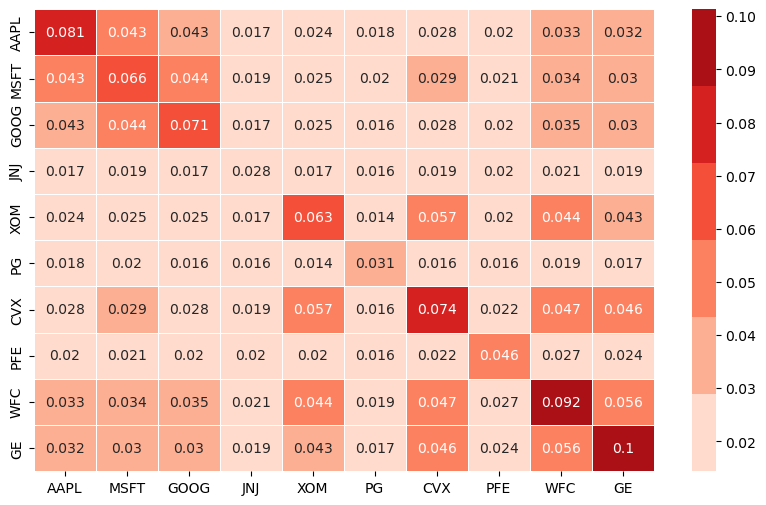

In [9]:
import seaborn as sns
df = pd.DataFrame(C, columns=names, index=names)
colormap = sns.color_palette("Reds")
ax = sns.heatmap(df, cmap=colormap, annot=True, linewidths=0.5, linecolor='white', cbar=True)
plt.show()

# display(pd.DataFrame(C, columns=names, index=names))

<AxesSubplot:>

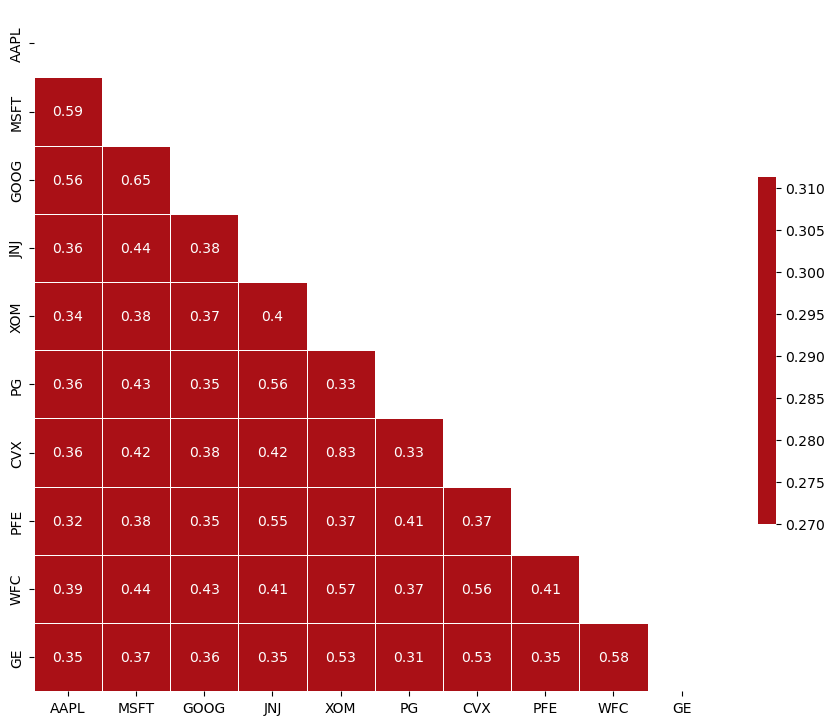

In [10]:
# plotiing correlation
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

correlation = pd.DataFrame(correlation_from_covariance(C), columns=names, index=names);

# colormap = sns.color_palette("Reds")
# ax = sns.heatmap(correlation, cmap=colormap, annot=True, linewidths=0.5, linecolor='white', cbar=True)
# plt.show()


mask = np.triu(np.ones_like(correlation, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("Reds")

sns.heatmap(correlation, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Mean-Variance Optimization (based on historical returns)

,Mean,Variance,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
0,0.034106,0.101309,0.000000e+00,0.000000e+00,0.000000e+00,1.932898e-13,3.513717e-13,2.163270e-13,1.248585e-13,8.665291e-14,2.554068e-13,1.000000e+00
1,0.048555,0.063258,0.000000e+00,0.000000e+00,1.534409e-14,1.412765e-13,2.447258e-01,1.083402e-01,4.882824e-14,5.571092e-14,4.274122e-14,6.469340e-01
2,0.063004,0.039779,3.666747e-17,0.000000e+00,2.108102e-17,7.108885e-02,2.239073e-01,2.876588e-01,2.709740e-18,1.645566e-17,7.545442e-18,4.173451e-01
3,0.077453,0.026075,1.565634e-20,1.596408e-20,2.589999e-17,2.821719e-01,1.716663e-01,3.364130e-01,0.000000e+00,3.692871e-17,1.702370e-17,2.097488e-01
4,0.091901,0.021430,0.000000e+00,5.387268e-18,0.000000e+00,3.723320e-01,1.252273e-01,3.981900e-01,1.226518e-18,7.750079e-02,9.020417e-19,2.674989e-02
5,0.106350,0.021066,2.473712e-02,3.358380e-19,4.829714e-02,3.590667e-01,8.292729e-02,3.705421e-01,0.000000e+00,1.144297e-01,1.990440e-18,1.453949e-18
6,0.120799,0.021392,8.155149e-02,5.576965e-03,4.845206e-02,3.362832e-01,4.593860e-02,3.456964e-01,2.382780e-03,1.341185e-01,5.840643e-19,3.993241e-18
7,0.135248,0.022166,1.304773e-01,2.458664e-02,6.371907e-02,3.230384e-01,3.455431e-02,3.104693e-01,7.928228e-18,1.131550e-01,0.000000e+00,0.000000e+00
8,0.149697,0.023484,1.798546e-01,4.562792e-02,6.367784e-02,3.028986e-01,2.370267e-03,2.812823e-01,6.085691e-03,1.182028e-01,5.583437e-16,7.072609e-16
9,0.164145,0.025343,2.370638e-01,6.615531e-02,5.755620e-02,2.636782e-01,0.000000e+00,2.459125e-01,0.000000e+00,1.296340e-01,5.562665e-18,3.708106e-18


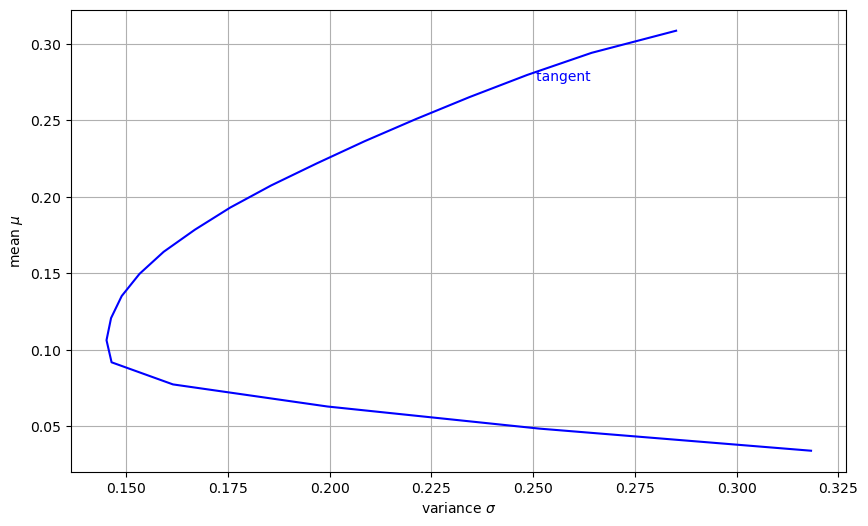

,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
Weight,0.692199,0.238609,0.030914,0.0,0.0,9.133048e-17,3.187554e-17,0.038278,6.079664e-17,0.0


In [22]:
res1 = optimize_frontier(R, C, rf)

# display_assets(names, R, C, color='blue')
display_frontier(res1, color='blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.show()
display(pd.DataFrame({'Weight': res1.W}, index=names).T)

## Black-litterman reverse optimization

In [12]:
# Calculate portfolio historical return and variance
mean, var = port_mean_var(W, R, C)

lmb = (mean - rf) / var  # Calculate risk aversion
Pi = np.dot(np.dot(lmb, C), W)  # Calculate equilibrium excess returns
print(Pi+rf, R)

[0.25503077 0.23161307 0.2226398  0.11558179 0.15530256 0.11518672
 0.17130857 0.12744721 0.1877169  0.17608646] [0.3086335  0.22635842 0.20719032 0.09691606 0.06681794 0.0935798
 0.11249463 0.11966454 0.08434027 0.03410613]


##### Mean-variance Optimization (based on equilibrium returns)

,Mean,Variance,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
0,0.034106,0.101309,0.000000e+00,0.000000e+00,0.000000e+00,1.932898e-13,3.513717e-13,2.163270e-13,1.248585e-13,8.665291e-14,2.554068e-13,1.000000e+00
1,0.048555,0.063258,0.000000e+00,0.000000e+00,1.534409e-14,1.412765e-13,2.447258e-01,1.083402e-01,4.882824e-14,5.571092e-14,4.274122e-14,6.469340e-01
2,0.063004,0.039779,3.666747e-17,0.000000e+00,2.108102e-17,7.108885e-02,2.239073e-01,2.876588e-01,2.709740e-18,1.645566e-17,7.545442e-18,4.173451e-01
3,0.077453,0.026075,1.565634e-20,1.596408e-20,2.589999e-17,2.821719e-01,1.716663e-01,3.364130e-01,0.000000e+00,3.692871e-17,1.702370e-17,2.097488e-01
4,0.091901,0.021430,0.000000e+00,5.387268e-18,0.000000e+00,3.723320e-01,1.252273e-01,3.981900e-01,1.226518e-18,7.750079e-02,9.020417e-19,2.674989e-02
5,0.106350,0.021066,2.473712e-02,3.358380e-19,4.829714e-02,3.590667e-01,8.292729e-02,3.705421e-01,0.000000e+00,1.144297e-01,1.990440e-18,1.453949e-18
6,0.120799,0.021392,8.155149e-02,5.576965e-03,4.845206e-02,3.362832e-01,4.593860e-02,3.456964e-01,2.382780e-03,1.341185e-01,5.840643e-19,3.993241e-18
7,0.135248,0.022166,1.304773e-01,2.458664e-02,6.371907e-02,3.230384e-01,3.455431e-02,3.104693e-01,7.928228e-18,1.131550e-01,0.000000e+00,0.000000e+00
8,0.149697,0.023484,1.798546e-01,4.562792e-02,6.367784e-02,3.028986e-01,2.370267e-03,2.812823e-01,6.085691e-03,1.182028e-01,5.583437e-16,7.072609e-16
9,0.164145,0.025343,2.370638e-01,6.615531e-02,5.755620e-02,2.636782e-01,0.000000e+00,2.459125e-01,0.000000e+00,1.296340e-01,5.562665e-18,3.708106e-18


,Mean,Variance,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
0,0.115187,0.030508,0.000000e+00,0.000000e+00,0.000000e+00,1.631972e-12,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.122547,0.021178,9.513808e-19,2.769749e-18,2.149455e-02,3.944173e-01,8.799139e-02,3.847729e-01,2.276805e-18,1.113239e-01,2.106166e-19,0.000000e+00
2,0.129907,0.021058,2.700950e-02,1.264693e-18,5.463168e-02,3.649937e-01,8.937221e-02,3.544119e-01,4.885801e-18,1.095810e-01,2.538617e-19,1.293657e-19
3,0.137267,0.021274,5.634669e-02,1.498163e-02,6.903906e-02,3.372671e-01,8.906319e-02,3.246527e-01,0.000000e+00,1.086497e-01,0.000000e+00,1.404934e-19
4,0.144628,0.021780,8.297389e-02,3.710385e-02,7.896204e-02,3.105082e-01,9.100753e-02,2.967285e-01,3.950968e-20,1.027160e-01,1.204230e-18,1.981626e-18
5,0.151988,0.022573,1.095177e-01,6.001358e-02,8.820474e-02,2.837499e-01,9.260523e-02,2.690031e-01,0.000000e+00,9.680672e-02,5.811974e-05,4.085318e-05
6,0.159348,0.023649,1.349025e-01,8.648960e-02,9.708316e-02,2.640724e-01,9.274538e-02,2.462854e-01,4.897176e-20,7.825611e-02,2.588843e-18,1.654236e-04
7,0.166708,0.025015,1.614532e-01,1.090812e-01,1.042537e-01,2.343979e-01,9.226037e-02,2.165056e-01,1.321964e-18,7.708784e-02,4.674938e-18,4.960108e-03
8,0.174068,0.026666,1.877492e-01,1.354204e-01,1.124635e-01,2.109313e-01,8.985476e-02,1.918450e-01,4.336809e-19,6.746813e-02,2.303930e-19,4.267758e-03
9,0.181429,0.028635,1.986847e-01,1.586658e-01,1.340272e-01,1.628206e-01,6.720931e-02,1.662707e-01,2.531937e-02,8.012867e-02,5.052606e-06,6.868598e-03


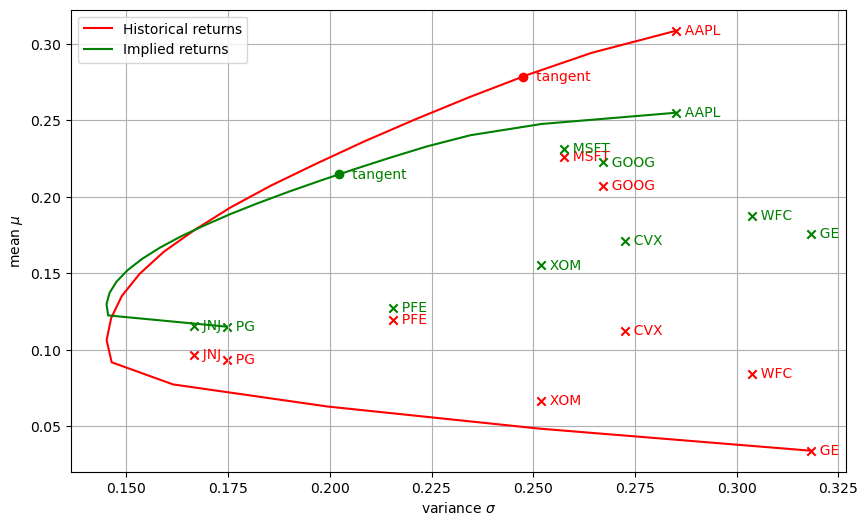

,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
Weight,0.316928,0.26791,0.161229,0.05997,0.054741,0.044184,0.037779,0.025899,0.018364,0.012996


In [13]:
res2 = optimize_frontier(Pi+rf, C, rf)

display_assets(names, R, C, color='red')
display_frontier(res1, label='Historical returns', color='red')
display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': res2.W}, index=names).T)

##### Determine views to the equilibrium returns and prepare views (Q) and link (P) matrices

In [14]:
def create_views_and_link_matrix(names, relative_views, absolute_views):
    r, a, c = len(relative_views), len(absolute_views), len(names)
    Q = [relative_views[i][3] for i in range(r)]  # view matrix
    if(absolute_views):
        for i in absolute_views:
            Q.append(i[1]);
    P = np.zeros([r+a, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i, v in enumerate(relative_views):
        name1, name2 = relative_views[i][0], relative_views[i][2]
        P[i, nameToIndex[name1]] = +1 if relative_views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if relative_views[i][1] == '>' else +1
    for i, v in enumerate(absolute_views):
        name  = absolute_views[i][0]
        P[i+r, nameToIndex[name]] += 1
    return array(Q), P

    

relative_views = [('AAPL', '>', 'CVX', 0.01),
         ('PFE', '>', 'JNJ', 0.02)]

absolute_views = [('MSFT', 0.2),
                    ('AAPL', 0.2),
                    ('GOOG', 0.2)]

Q, P = create_views_and_link_matrix(names, relative_views, absolute_views)
print('Views Matrix')
display(DataFrame({'Views':Q}))
print('Link Matrix')
P = DataFrame(P)
P.columns = ['AAPL', 'MSFT', 'GOOG', 'JNJ', 'XOM', 'PG', 'CVX', 'PFE', 'WFC', 'GE']
display(P)

Views Matrix


,Views
0,0.01
1,0.02
2,0.2
3,0.2
4,0.2


Link Matrix


,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Optimization based on Equilibrium returns with adjusted views

,Mean,Variance,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
0,0.115187,0.030508,0.000000e+00,0.000000e+00,0.000000e+00,1.631972e-12,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.122547,0.021178,9.513808e-19,2.769749e-18,2.149455e-02,3.944173e-01,8.799139e-02,3.847729e-01,2.276805e-18,1.113239e-01,2.106166e-19,0.000000e+00
2,0.129907,0.021058,2.700950e-02,1.264693e-18,5.463168e-02,3.649937e-01,8.937221e-02,3.544119e-01,4.885801e-18,1.095810e-01,2.538617e-19,1.293657e-19
3,0.137267,0.021274,5.634669e-02,1.498163e-02,6.903906e-02,3.372671e-01,8.906319e-02,3.246527e-01,0.000000e+00,1.086497e-01,0.000000e+00,1.404934e-19
4,0.144628,0.021780,8.297389e-02,3.710385e-02,7.896204e-02,3.105082e-01,9.100753e-02,2.967285e-01,3.950968e-20,1.027160e-01,1.204230e-18,1.981626e-18
5,0.151988,0.022573,1.095177e-01,6.001358e-02,8.820474e-02,2.837499e-01,9.260523e-02,2.690031e-01,0.000000e+00,9.680672e-02,5.811974e-05,4.085318e-05
6,0.159348,0.023649,1.349025e-01,8.648960e-02,9.708316e-02,2.640724e-01,9.274538e-02,2.462854e-01,4.897176e-20,7.825611e-02,2.588843e-18,1.654236e-04
7,0.166708,0.025015,1.614532e-01,1.090812e-01,1.042537e-01,2.343979e-01,9.226037e-02,2.165056e-01,1.321964e-18,7.708784e-02,4.674938e-18,4.960108e-03
8,0.174068,0.026666,1.877492e-01,1.354204e-01,1.124635e-01,2.109313e-01,8.985476e-02,1.918450e-01,4.336809e-19,6.746813e-02,2.303930e-19,4.267758e-03
9,0.181429,0.028635,1.986847e-01,1.586658e-01,1.340272e-01,1.628206e-01,6.720931e-02,1.662707e-01,2.531937e-02,8.012867e-02,5.052606e-06,6.868598e-03


,Mean,Variance,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
0,0.117588,0.030508,0.000000e+00,0.000000e+00,0.000000,2.585154e-13,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.124295,0.021368,1.716466e-18,7.006986e-20,0.000627,4.144720e-01,6.714337e-02,3.963281e-01,0.000000e+00,1.214294e-01,2.035949e-18,3.552771e-19
2,0.131001,0.021096,7.795823e-03,9.484201e-19,0.040958,3.585084e-01,8.999132e-02,3.818451e-01,2.654801e-18,1.209013e-01,0.000000e+00,0.000000e+00
3,0.137708,0.021111,3.973011e-02,0.000000e+00,0.063959,3.455132e-01,9.602684e-02,3.482106e-01,0.000000e+00,1.065604e-01,4.590376e-18,1.391570e-22
4,0.144415,0.021419,5.887611e-02,1.987051e-02,0.076947,3.221298e-01,1.069804e-01,3.130577e-01,3.260567e-05,1.021058e-01,3.428927e-18,8.800799e-19
5,0.151121,0.022869,4.979669e-02,4.979024e-02,0.049792,2.621536e-01,4.975946e-02,3.397014e-01,4.975835e-02,4.976764e-02,4.974109e-02,4.973990e-02
6,0.157828,0.022807,9.644835e-02,6.448541e-02,0.101976,2.682344e-01,1.046023e-01,2.551133e-01,1.092617e-02,9.657588e-02,2.219963e-19,1.638561e-03
7,0.164535,0.023924,1.102676e-01,9.534900e-02,0.105804,2.256893e-01,6.649920e-02,2.625046e-01,4.937407e-02,7.626154e-02,9.623575e-19,8.250257e-03
8,0.171242,0.025181,1.265804e-01,1.093094e-01,0.119369,2.039154e-01,8.963170e-02,2.082224e-01,5.450496e-02,8.543820e-02,9.950834e-19,3.028339e-03
9,0.177948,0.026776,1.460040e-01,1.334715e-01,0.131458,1.717155e-01,6.057371e-02,2.020498e-01,6.088376e-02,7.097834e-02,1.144108e-02,1.142424e-02


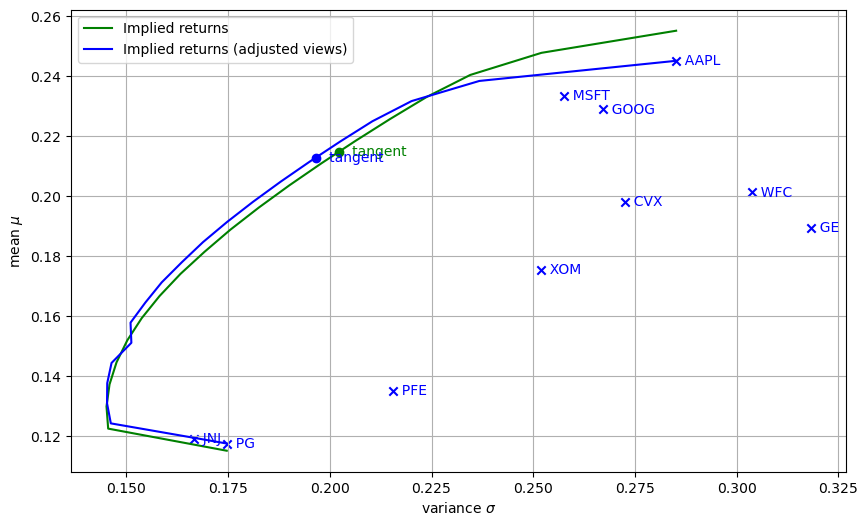

,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
Weight,0.316928,0.26791,0.161229,0.05997,0.054741,0.044184,0.037779,0.025899,0.018364,0.012996


In [15]:
tau = 0.25  # scaling factor

# Calculate omega - uncertainty matrix about views
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))  # 0.025 * P * C * transpose(P)
# Calculate equilibrium excess returns with views incorporated
sub_a = np.linalg.inv(np.dot(tau, C))  #(tau.C) inverse
sub_b = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), P)  # (P^T.omega^-1).P
sub_c = np.dot(np.linalg.inv(np.dot(tau, C)), Pi)  # ((Tau.C)^-1).Pi
sub_d = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), Q)   # (P^T.omega^-1).Q
Pi_adj = np.dot(np.linalg.inv(sub_a + sub_b), (sub_c + sub_d))   

res3 = optimize_frontier(Pi_adj + rf, C, rf)


# display_frontier(res1, label='Historic Return', color='red')
# display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
display_assets(names, Pi_adj+rf, C, color='blue')
display_frontier(res3, label='Implied returns (adjusted views)', color='blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': res2.W}, index=names).T)


In [16]:
display(pd.DataFrame({'Weight': res2.W}, index=names).T)
display(pd.DataFrame({'Weight': res3.W}, index=names).T)

,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
Weight,0.316928,0.26791,0.161229,0.05997,0.054741,0.044184,0.037779,0.025899,0.018364,0.012996


,AAPL,MSFT,GOOG,JNJ,XOM,PG,CVX,PFE,WFC,GE
Weight,0.232437,0.244216,0.182581,0.036426,0.052567,0.04168,0.133817,0.046393,0.017468,0.012415


In [17]:
# import matplotlib.pyplot as plt
# labels = ['AAPL', 'MSFT', 'GOOG', 'JNJ', 'XOM', 'PG', 'CVX', 'PFE', 'WFC', 'GE']
# pre_weights = res2.W

# fig, ax = plt.subplots()
# ax.pie(pre_weights, labels=labels)


Text(0.5, 1.0, 'Posterior Weights after Applying Views')

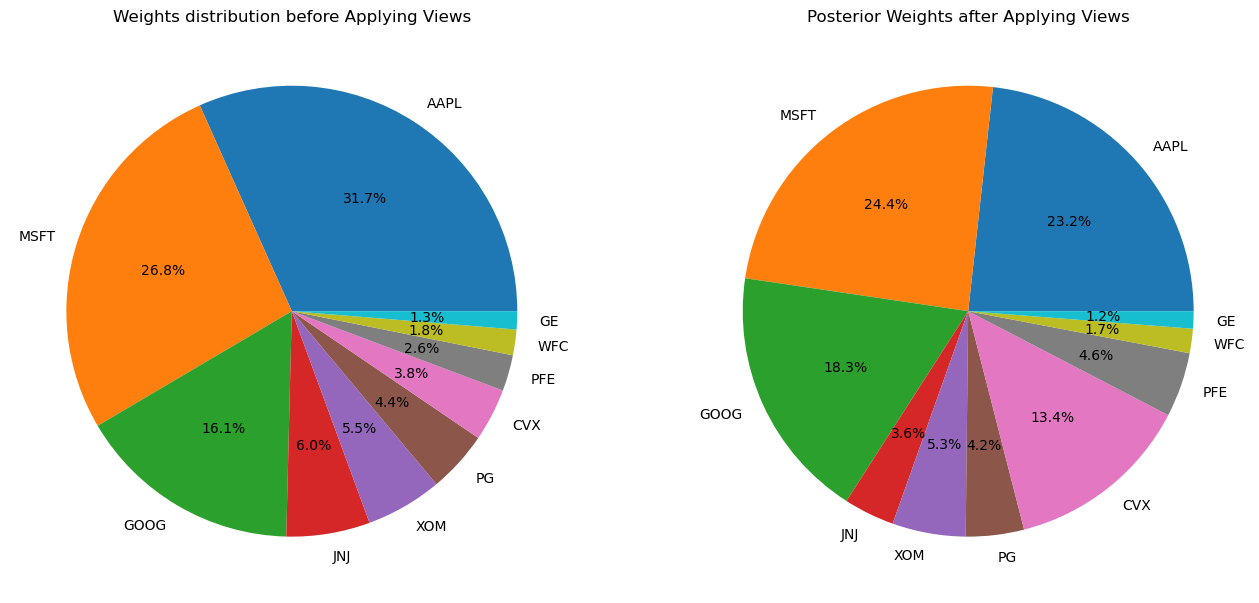

In [18]:
labels = ['AAPL', 'MSFT', 'GOOG', 'JNJ', 'XOM', 'PG', 'CVX', 'PFE', 'WFC', 'GE']
pre_weights = res2.W
post_weights = res3.W
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# ...
axs[0].pie(pre_weights,labels = labels, autopct = '%1.1f%%')
axs[0].set_title('Weights distribution before Applying Views')
# ...
axs[1].pie(post_weights,labels = labels, autopct = '%1.1f%%')
axs[1].set_title('Posterior Weights after Applying Views')